In [10]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

geoLoc = Nominatim(user_agent="GetLoc")
june_july_dataset_path = 'data/June and July dataset/'
jan_feb_dataset_path = 'data/January_February_dataset/'

ANALYZE JUNE/JULY DATA

In [2]:
livevideos_part1 = pd.read_json(june_july_dataset_path + 'LiveVideos_part1.json', lines=True)
livevideos_part2 = pd.read_json(june_july_dataset_path + 'LiveVideos_part2.json', lines=True)
livevideos = pd.concat([livevideos_part1, livevideos_part2], ignore_index=True)
del livevideos_part1, livevideos_part2

In [3]:
viewers_by_fetch_part1 = pd.read_json(june_july_dataset_path + 'Viewers_by_fetch_part1.json', lines=True)
viewers_by_fetch_part2 = pd.read_json(june_july_dataset_path + 'viewers_by_fetch_part2.json', lines=True)
viewers_by_fetch = pd.concat([viewers_by_fetch_part1, viewers_by_fetch_part2], ignore_index=True)
del viewers_by_fetch_part1, viewers_by_fetch_part2

In [4]:
# viewers_all_location_part1 = pd.read_json(june_july_dataset_path + 'viewers_all_location_part1.json', lines=True)
# viewers_all_location_part2 = pd.read_json(june_july_dataset_path + 'viewers_all_locations.json', lines=True)
# viewers_all_location = pd.concat([viewers_all_location_part1, viewers_all_location_part2], ignore_index=True)
# del viewers_all_location_part1, viewers_all_location_part2

In [5]:
viewers_by_fetch["video"] = viewers_by_fetch["video"].apply(lambda x: x['$oid'] if isinstance(x, dict) else x)
livevideos["_id"] = livevideos["_id"].apply(lambda x: x['$oid'] if isinstance(x, dict) else x)
livevideos["created_time"] = pd.to_datetime(livevideos["created_time"])
viewers_by_fetch["refresh_time"] = pd.to_datetime(viewers_by_fetch["refresh_time"])

In [6]:
viewers_count = viewers_by_fetch[['video', 'viewers_count']]
max_viewers_count = viewers_count[['video', 'viewers_count']].groupby('video').max().reset_index()
count_by_viewers = max_viewers_count.groupby('viewers_count').size().reset_index(name='count')
count_by_viewers_1000 = count_by_viewers[count_by_viewers['viewers_count'] >= 1000]
display(f"Live videos with maximum concurrent viewers >= 1000: {sum(count_by_viewers_1000['count'])}")
count_by_viewers_5000 = count_by_viewers[count_by_viewers['viewers_count'] >= 5000]
display(f"Live videos with maximum concurrent viewers >= 5000: {sum(count_by_viewers_5000['count'])}")
count_by_viewers_10000 = count_by_viewers[count_by_viewers['viewers_count'] >= 10000]
display(f"Live videos with maximum concurrent viewers >= 10000: {sum(count_by_viewers_10000['count'])}")
count_by_viewers_25000 = count_by_viewers[count_by_viewers['viewers_count'] >= 25000]
display(f"Live videos with maximum concurrent viewers >= 25000: {sum(count_by_viewers_25000['count'])}")
count_by_viewers_50000 = count_by_viewers[count_by_viewers['viewers_count'] >= 50000]
display(f"Live videos with maximum concurrent viewers >= 50000: {sum(count_by_viewers_50000['count'])}")


'Live videos with maximum concurrent viewers >= 1000: 19647'

'Live videos with maximum concurrent viewers >= 5000: 1973'

'Live videos with maximum concurrent viewers >= 10000: 610'

'Live videos with maximum concurrent viewers >= 25000: 123'

'Live videos with maximum concurrent viewers >= 50000: 30'

'5b240279fce457459c811411'

'5b23ff4ffce457459c810ec7'

'5b3a43d242282725a4ec2c60'

'5b33c98042282735f0865dfe'

'5b374e9c42282735f08e5869'

'5b3a486242282725a4ec34c1'

'5b2f494f42282735f0780d31'

'5b27b3f5fce457459c8703f9'

'5b240d28fce457459c812620'

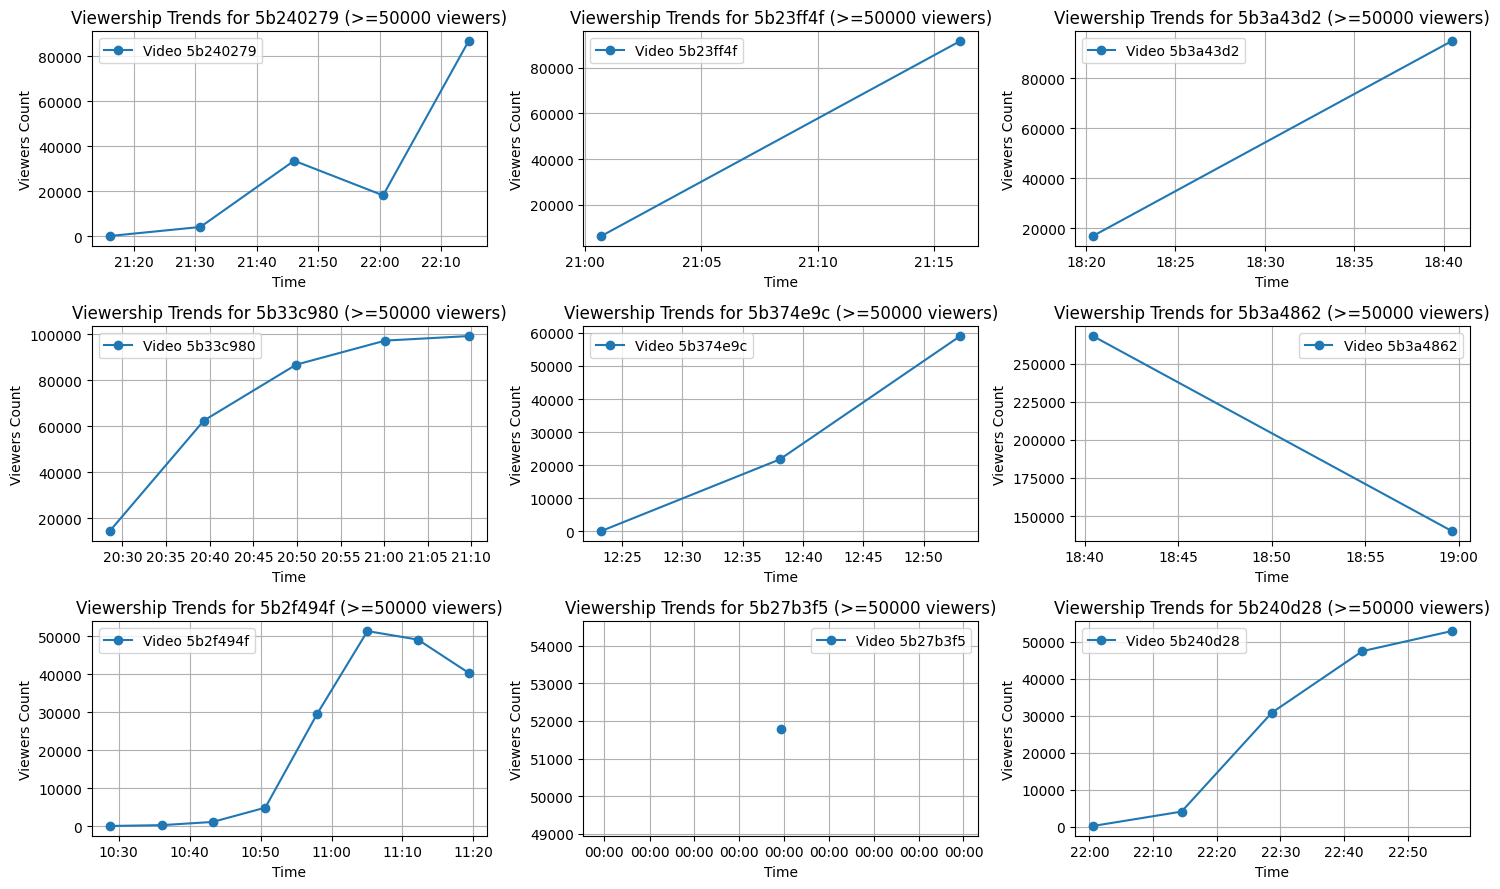

In [11]:
max_viewers = viewers_by_fetch.groupby('video')['viewers_count'].max()
viewers_threshold = 50000
sample_size = 9
videos_with_high_viewers = max_viewers[max_viewers >= viewers_threshold].index
sample_videos = np.random.choice(videos_with_high_viewers, size=min(sample_size, len(videos_with_high_viewers)), replace=False)
filtered_viewers = viewers_by_fetch[viewers_by_fetch['video'].isin(sample_videos)]
filtered_livevideo = livevideos[livevideos['_id'].isin(sample_videos)]
merged_df = pd.merge(filtered_viewers, filtered_livevideo, left_on='video', right_on='_id')

# Determine the number of rows and columns for the subplots
ncols = 3
nrows = (len(sample_videos) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Define the date formatter to show only hour and minute
time_formatter = DateFormatter('%H:%M')

for ax, video_id in zip(axes, sample_videos):
    video_data = merged_df[merged_df['video'] == video_id]
    ax.plot(video_data['refresh_time'], video_data['viewers_count'], marker='o', label=f'Video {video_id[:8]}')  # Truncate video_id
    display(video_id)
    ax.set_title(f'Viewership Trends for {video_id[:8]} (>={viewers_threshold} viewers)')  # Truncate video_id
    ax.set_xlabel('Time')
    ax.set_ylabel('Viewers Count')
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_formatter(time_formatter)  # Set the formatter for x-axis

# Hide any unused subplots
for i in range(len(sample_videos), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [13]:
viewers_count = viewers_by_fetch[['video', 'viewers_count']]
max_viewers_count = viewers_count[['video', 'viewers_count']].groupby('video').max().reset_index()
def count_by_viewers(threshold, data_points = 4):
    videos_with_high_viewers = max_viewers_count[max_viewers_count['viewers_count'] >= threshold]['video']
    rows_per_video = viewers_by_fetch[viewers_by_fetch['video'].isin(videos_with_high_viewers)].groupby('video').size()
    videos_with_more_than_5_rows = rows_per_video[rows_per_video >= data_points].index
    count_videos = len(videos_with_more_than_5_rows)
    display(f"Live videos with maximum concurrent viewers >= {threshold} and more than {data_points} data points: {count_videos}")

count_by_viewers(1000)
count_by_viewers(5000)
count_by_viewers(10000)
count_by_viewers(20000)
count_by_viewers(50000)

'Live videos with maximum concurrent viewers >= 1000 and more than 4 data points: 8710'

'Live videos with maximum concurrent viewers >= 5000 and more than 4 data points: 870'

'Live videos with maximum concurrent viewers >= 10000 and more than 4 data points: 275'

'Live videos with maximum concurrent viewers >= 20000 and more than 4 data points: 88'

'Live videos with maximum concurrent viewers >= 50000 and more than 4 data points: 12'

'5b19848bfce457459c6d3d92'

'5b2f494f42282735f0780d31'

'5b31309442282735f07ee697'

'5ab54b90fce4575490eed4e6'

'5b2e3b024228273520a7b258'

'5ab514effce4575490ed381b'

'5afed88cfce45733149429a3'

'5b3aa85242282725a4ecd6ed'

'5b23ff07fce457459c810e4a'

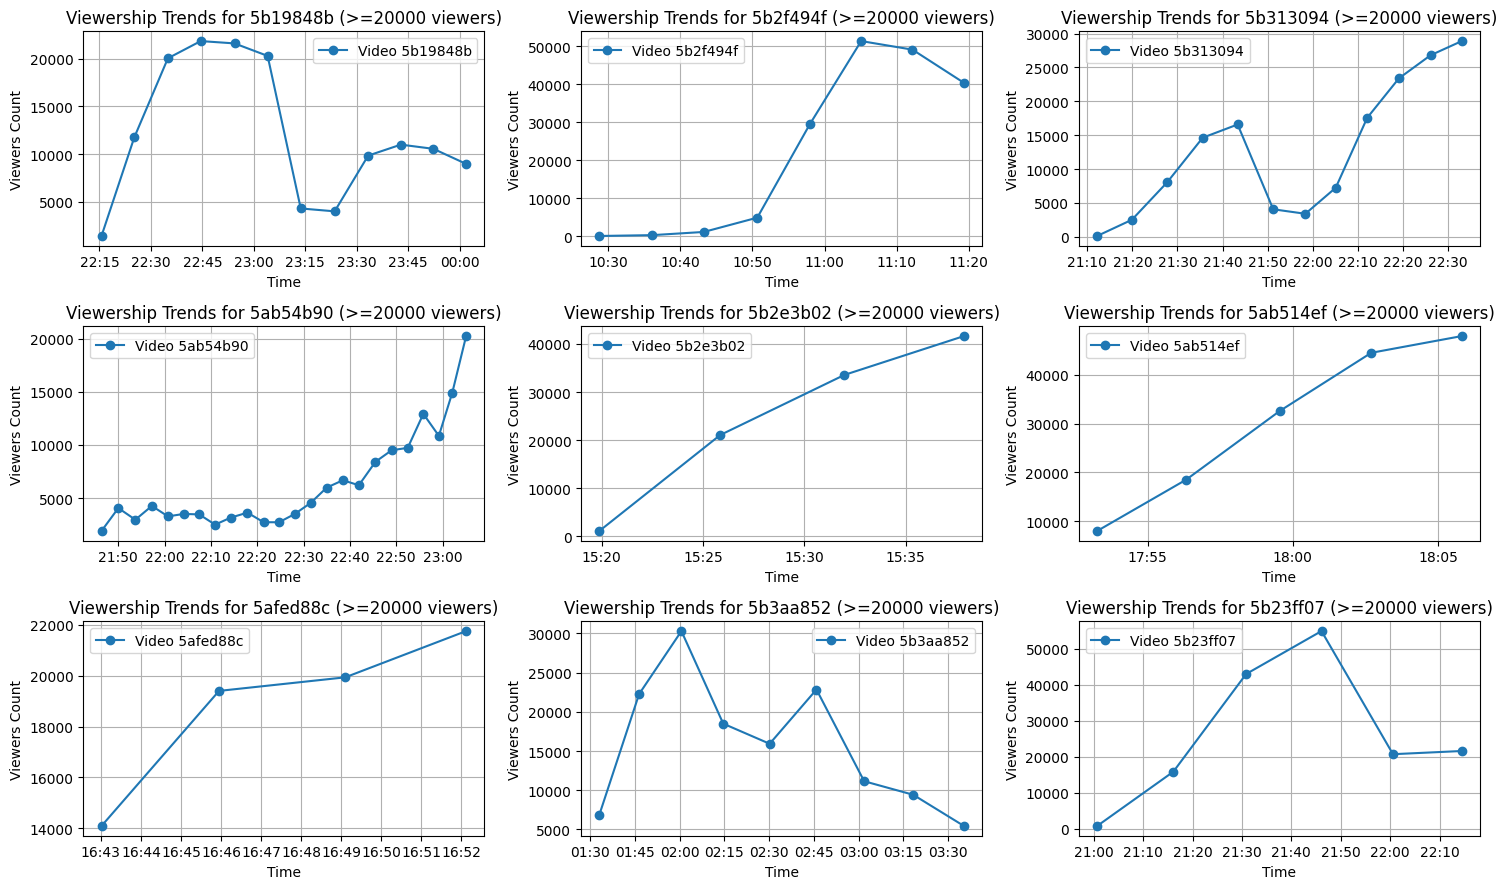

In [14]:
viewers_threshold = 20000
sample_size = 9
data_points = 4
videos_with_high_viewers = max_viewers_count[max_viewers_count['viewers_count'] >= viewers_threshold]['video']
rows_per_video = viewers_by_fetch[viewers_by_fetch['video'].isin(videos_with_high_viewers)].groupby('video').size()
videos_with_more_than_5_rows = rows_per_video[rows_per_video >= data_points].index
sample_videos = np.random.choice(videos_with_more_than_5_rows, size=min(sample_size, len(videos_with_more_than_5_rows)), replace=False)
filtered_viewers = viewers_by_fetch[viewers_by_fetch['video'].isin(sample_videos)]
filtered_livevideo = livevideos[livevideos['_id'].isin(sample_videos)]
merged_df = pd.merge(filtered_viewers, filtered_livevideo, left_on='video', right_on='_id')

# Determine the number of rows and columns for the subplots
ncols = 3
nrows = (len(sample_videos) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Define the date formatter to show only hour and minute
time_formatter = DateFormatter('%H:%M')

for ax, video_id in zip(axes, sample_videos):
    video_data = merged_df[merged_df['video'] == video_id]
    ax.plot(video_data['refresh_time'], video_data['viewers_count'], marker='o', label=f'Video {video_id[:8]}')  # Truncate video_id
    display(video_id)
    ax.set_title(f'Viewership Trends for {video_id[:8]} (>={viewers_threshold} viewers)')  # Truncate video_id
    ax.set_xlabel('Time')
    ax.set_ylabel('Viewers Count')
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_formatter(time_formatter)  # Set the formatter for x-axis

# Hide any unused subplots
for i in range(len(sample_videos), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

PREPARAR DATASET  
Identificar sesiones que se ajustan a >>> 1000  
Ver resoluciones  
Momento exacto en el que entra un usuario -> no lo tenemos  
Tener en cuenta tiempo que tarda vm en arrancar, el momento que llega el usuario es relevante  
Definir modelo  
Función objetivo servidores utilizados por unidad de tiempo  
Latencia media por saltos entre servidores  
Algoritmos naive (1 server por publisher, 1 servidor padre solo puede conectar a servidores hoja)  
Varias sesiones simultáneas en mismo stack (reutilizar servidores para nuevas sesiones)  
Un pequeño experimento no simulado en el paper primero -> impacto que tiene en un sub que el media llegue desde el server al que está conectado/2 saltos/3 saltos...  
- 1 publisher + 1 subscriber y vamos metiendo servidores entre ellos (calcular rtt)
- Grabar ambos browsers para ver el delay entre fotogramas entre ambos
- Justifica la necesidad del paper  

Mediasoup solo permite 1 core por sesión salvo si conectas cores (confuso para el paper, obviarlo, pero de cara a futuro para OV es importante acordarse)

ANALYZE JANUARY/FEBRUARY EXTENDED DATA

In [26]:
livevideos_part1 = pd.read_json(jan_feb_dataset_path + 'videos_period1.json', lines=True)
livevideos_part2 = pd.read_json(jan_feb_dataset_path + 'videos_period2.json', lines=True)
jan_livevideos = pd.concat([livevideos_part1, livevideos_part2], ignore_index=True)
del livevideos_part1, livevideos_part2
jan_viewers_by_fetch = pd.read_json(jan_feb_dataset_path + 'viewers_by_fetch_period1and2.json', lines=True)

In [28]:
jan_viewers_by_fetch["video"] = jan_viewers_by_fetch["video"].apply(lambda x: x['$oid'] if isinstance(x, dict) else x)
jan_livevideos["_id"] = jan_livevideos["_id"].apply(lambda x: x['$oid'] if isinstance(x, dict) else x)
jan_livevideos["created_time"] = pd.to_datetime(jan_livevideos["created_time"], format="ISO8601")
jan_viewers_by_fetch["refresh_time"] = pd.to_datetime(jan_viewers_by_fetch["refresh_time"])

C:\Users\millenium\AppData\Local\Temp\ipykernel_25656\3003780137.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  jan_livevideos["created_time"] = pd.to_datetime(jan_livevideos["created_time"], format="ISO8601")


In [47]:
jan_viewers_count = jan_viewers_by_fetch[['video', 'viewers_count']]
max_jan_viewers_count = jan_viewers_count.groupby('video').max().reset_index()
jan_count_by_viewers = max_jan_viewers_count.groupby('viewers_count').size().reset_index(name='count')
jan_count_by_viewers_1000 = jan_count_by_viewers[jan_count_by_viewers['viewers_count'] >= 1000]
display(f"Live videos with maximum concurrent viewers >= 1000: {sum(jan_count_by_viewers_1000['count'])}")
jan_count_by_viewers_5000 = jan_count_by_viewers[jan_count_by_viewers['viewers_count'] >= 5000]
display(f"Live videos with maximum concurrent viewers >= 5000: {sum(jan_count_by_viewers_5000['count'])}")
jan_count_by_viewers_10000 = jan_count_by_viewers[jan_count_by_viewers['viewers_count'] >= 10000]
display(f"Live videos with maximum concurrent viewers >= 10000: {sum(jan_count_by_viewers_10000['count'])}")
jan_count_by_viewers_25000 = jan_count_by_viewers[jan_count_by_viewers['viewers_count'] >= 25000]
display(f"Live videos with maximum concurrent viewers >= 25000: {sum(jan_count_by_viewers_25000['count'])}")
jan_count_by_viewers_50000 = jan_count_by_viewers[jan_count_by_viewers['viewers_count'] >= 50000]
display(f"Live videos with maximum concurrent viewers >= 50000: {sum(jan_count_by_viewers_50000['count'])}")

'Live videos with maximum concurrent viewers >= 1000: 10041'

'Live videos with maximum concurrent viewers >= 5000: 730'

'Live videos with maximum concurrent viewers >= 10000: 189'

'Live videos with maximum concurrent viewers >= 25000: 23'

'Live videos with maximum concurrent viewers >= 50000: 3'

'5a7be8c4fce45723086a3b2c'

'5a7bf852fce45723086a914e'

'5a849b4ffce457230889779d'

'5a7cbc56fce45723086ef4e0'

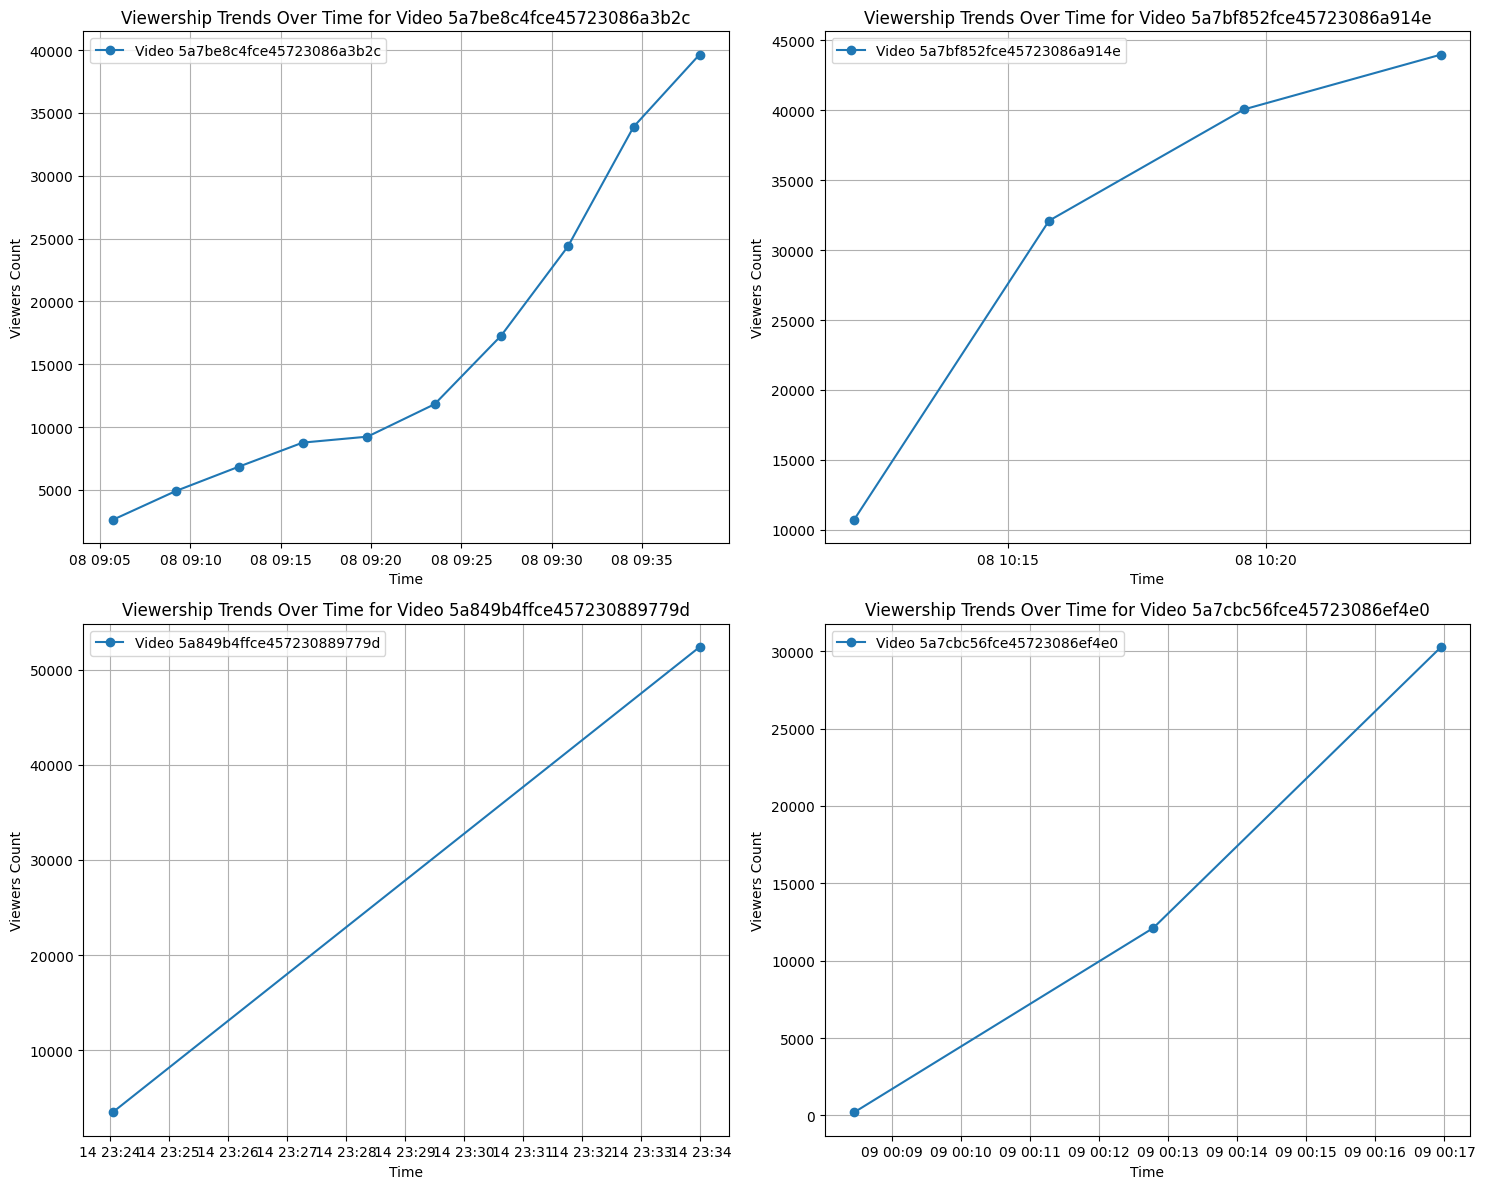

In [31]:
max_viewers = jan_viewers_by_fetch.groupby('video')['viewers_count'].max()
viewers_threshold = 25000
sample_size = 4
videos_with_high_viewers = max_viewers[max_viewers >= viewers_threshold].index
sample_videos = np.random.choice(videos_with_high_viewers, size=min(sample_size, len(videos_with_high_viewers)), replace=False)
filtered_viewers = jan_viewers_by_fetch[jan_viewers_by_fetch['video'].isin(sample_videos)]
filtered_livevideo = jan_livevideos[jan_livevideos['_id'].isin(sample_videos)]
merged_df = pd.merge(filtered_viewers, filtered_livevideo, left_on='video', right_on='_id')

# Determine the number of rows and columns for the subplots
ncols = 2
nrows = (len(sample_videos) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6 * nrows))

# Flatten axes array for easy iteration
axes = axes.flatten()

for ax, video_id in zip(axes, sample_videos):
    video_data = merged_df[merged_df['video'] == video_id]
    ax.plot(video_data['refresh_time'], video_data['viewers_count'], marker='o', label=f'Video {video_id}')
    display(video_id)
    ax.set_title(f'Viewership Trends Over Time for Video {video_id}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Viewers Count')
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for i in range(len(sample_videos), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()